### 01_develop_test_data_cornwall_icb — Cornwall ICB Test Slice Builder

### What this step does
Creates a **small, reproducible test dataset** for **Cornwall & Isles of Scilly ICB** by trimming master files to ICB-only rows, standardising key columns, and performing light QA. Outputs are written to `data/raw/test_data_ICB_level/` for fast iteration without loading full region-wide datasets.

### Why this is useful
- Faster development and debugging on a compact, realistic slice  
- Consistent schemas (names/types) across inputs for downstream notebooks  
- Early detection of join/key issues (e.g., name↔code mismatches)  
- Shareable, auditable artefacts with a manifest and README

### Inputs (relative paths)
- **Demographics:**  
  `demographics/census_2021_general_health_lsoas.csv`  
  `demographics/Rural_Urban_Classification_(2021)_of_LSOAs_in_EW.csv`  
  `demographics/lsoa_imd_2019.csv`
- **Geospatial (LSOA):**  
  `gkpg/LSOA_5-year_age_segment.gpkg` (layer: `LSOA_5-year_segment_master`)  
  `gkpg/LSOA_discrete_age.gpkg` (layer: `LSOA_continuous_age_master`)
- **Travel:**  
  `travel_data/LSOA_to_LSOA_travel_time.csv`
- **Health infrastructure:**  
  `health_infrastructure/NHS_SW_Acute_Hospitals_Capability.csv`  
  `health_infrastructure/NHS_SW_Community_Diagnostic_Centres_Capability.csv`  
  `health_infrastructure/NHS_SW_Community_Hospitals_Capability.csv`

### Outputs (created)
- Lookup: `cornwall_icb_lsoa_lookup.csv`  
- Demographics: `demographics_general_health_icb.csv`, `demographics_age_5y_icb.gpkg`, `demographics_age_continuous_icb.gpkg`  
- Context: `ruc_icb.csv`, `imd_icb.csv`  
- Travel: `travel_matrix_lsoa_icb.csv`  
- Sites: `nhs_sites_acute_icb.csv`, `nhs_sites_cdc_icb.csv`, `nhs_sites_community_icb.csv`  
- Provenance: `_README.md`, `_MANIFEST.json`

### Key operations
- Filter LSOAs by **ICB name** from 5-year GPKG (`ICB23NM`)  
- Standardise primary key to **`lsoa_code` = `lsoa21cd`** (lowercase)  
- Join travel **names → codes**; retain both for transparency  
- Coerce numeric counts (non-negative); record CRS for GPKGs

### Assumptions & contracts
- Authoritative key: `lsoa21cd` (ONS 2021)  
- ICB match: exact value recorded in README (e.g., “Cornwall and Isles of Scilly ICB”)  
- IMD field `IMD19` documented as **rank or score** in README  
- Travel time is **minutes**, ≥ 0

### Success criteria
- All outputs exist and contain **only Cornwall & IoS** records  
- No unresolved travel name→code matches (0%)  
- Demographic category sums align with totals (within tolerance)  
- README + MANIFEST include counts, filters, and CRS notes

In [1]:
# --- Step 0: Imports & File Configuration (Notebook preamble) ---
from __future__ import annotations

from datetime import datetime
from pathlib import Path
from typing import Dict, List

import json
import warnings

import geopandas as gpd  # noqa: F401  # (used later)
import numpy as np       # noqa: F401  # (used later)
import pandas as pd
import re
import matplotlib.pyplot as plt

# Optional (useful in notebooks)
try:
    from IPython.display import display  # type: ignore
except Exception:  # pragma: no cover
    display = print  # fallback

In [2]:
# ---------------------------------------------------------------------
# Display preferences (quick audits)
# ---------------------------------------------------------------------
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 120)
pd.set_option("display.float_format", lambda x: f"{x:,.3f}")


In [3]:
# ---------------------------------------------------------------------
# File imports only (absolute data root)
# ---------------------------------------------------------------------
from pathlib import Path
import geopandas as gpd

DATA_ROOT = Path(
    "/Users/rosstaylor/Downloads/Code Repositories/REACH Map (NHS SW)/GitHub Repo/REACH-Map-NHS-SW/data/raw"
)

# Input file paths (relative to DATA_ROOT)
ruc_path = DATA_ROOT / "demographics" / "Rural_Urban_Classification_(2021)_of_LSOAs_in_EW.csv"
general_health_path = DATA_ROOT / "demographics" / "census_2021_general_health_lsoas.csv"
imd_path = DATA_ROOT / "demographics" / "lsoa_imd_2019.csv"

age_5y_gpkg = DATA_ROOT / "gkpg" / "LSOA_5-year_age_segment.gpkg"
age_continuous_gpkg = DATA_ROOT / "gkpg" / "LSOA_discrete_age.gpkg"

sites_acute_path = DATA_ROOT / "health_infrastructure" / "NHS_SW_Acute_Hospitals_Capability.csv"
sites_cdc_path = DATA_ROOT / "health_infrastructure" / "NHS_SW_Community_Diagnostic_Centres_Capability.csv"
sites_community_path = DATA_ROOT / "health_infrastructure" / "NHS_SW_Community_Hospitals_Capability.csv"

travel_matrix_path = DATA_ROOT / "travel_data" / "LSOA_to_LSOA_travel_time.csv"

# GPKG layers
age_5y_layer = "LSOA_5-year_segment_master"
age_continuous_layer = "LSOA_continuous_age_master"

# --- Read files into memory ---
# Tabular
ruc_df = pd.read_csv(ruc_path)
general_health_df = pd.read_csv(general_health_path)
imd_df = pd.read_csv(imd_path)
sites_acute_df = pd.read_csv(sites_acute_path)
sites_cdc_df = pd.read_csv(sites_cdc_path)
sites_community_df = pd.read_csv(sites_community_path)
travel_matrix_df = pd.read_csv(travel_matrix_path)

# Geopackages
age_5y_gdf = gpd.read_file(age_5y_gpkg, layer=age_5y_layer)
age_continuous_gdf = gpd.read_file(age_continuous_gpkg, layer=age_continuous_layer)

In [4]:
# --- Step 1: Create Cornwall-only LSOA lookup (exact ICB name) ---



# Exact ICB display name to match (from inspection)
ICB_NAME_EXACT = "NHS Cornwall and the Isles of Scilly Integrated Care Board"

# Output directory for test-slice artefacts
OUT_DIR = DATA_ROOT / "test_data_ICB_level"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Identify the ICB name column (prefer the known canonical name)
icb_col = "ICB23NM" if "ICB23NM" in age_5y_gdf.columns else None
if icb_col is None:
    candidates = [c for c in age_5y_gdf.columns if c.lower() in {"icb23nm", "icb_name"}]
    if not candidates:
        raise KeyError(
            f"ICB name column not found in age_5y_gdf. "
            f"Available columns: {list(age_5y_gdf.columns)}"
        )
    icb_col = candidates[0]

# Filter to the exact ICB name (case-insensitive equality)
mask_icb = (
    age_5y_gdf[icb_col].astype(str).str.strip().str.casefold()
    == ICB_NAME_EXACT.strip().casefold()
)
cornwall_gdf = age_5y_gdf.loc[mask_icb].copy()

print(
    f"Matched rows for '{ICB_NAME_EXACT}': {len(cornwall_gdf):,} "
    f"(of {len(age_5y_gdf):,} total in layer)"
)

# Build a clean LSOA lookup DataFrame for the Cornwall ICB
required_cols = [
    "lsoa21cd", "lsoa21nm", "msoa21cd", "msoa21nm",
    "ladcd", "ladnm", icb_col, "lat", "long", "bng_e", "bng_n",
    "geometry"  # NEW: include geometry
]
missing = [c for c in required_cols if c not in cornwall_gdf.columns]
if missing:
    raise KeyError(f"Missing expected columns in GPKG for lookup: {missing}")

cornwall_lookup = (
    cornwall_gdf[required_cols]
    .rename(
        columns={
            "lsoa21cd": "lsoa_code",
            "lsoa21nm": "lsoa_name",
            "msoa21cd": "msoa21cd",
            "msoa21nm": "msoa21nm",
            "ladcd": "ladcd",
            "ladnm": "ladnm",
            icb_col: "icb_name",
            "lat": "lat",
            "long": "long",
            "bng_e": "bng_e",
            "bng_n": "bng_n",
            # geometry keeps same name
        }
    )
    .drop_duplicates(subset=["lsoa_code"])
    .sort_values(["ladnm", "msoa21nm", "lsoa_name"])
    .reset_index(drop=True)
)

# Ensure GeoDataFrame semantics are preserved  # NEW
cornwall_lookup = gpd.GeoDataFrame(cornwall_lookup, geometry="geometry", crs=cornwall_gdf.crs)

print(f"Unique LSOAs in Cornwall ICB: {cornwall_lookup['lsoa_code'].nunique():,}")
try:
    display(cornwall_lookup.head(1))
except Exception:
    print(cornwall_lookup.head(1))

# Save the lookup for downstream filtering

# 1) GeoPackage (preserves real geometry + CRS)
out_gpkg = OUT_DIR / "cornwall_icb_lsoa_lookup.gpkg"
cornwall_lookup.to_file(out_gpkg, layer="cornwall_icb_lsoa_lookup", driver="GPKG")
print(f"Saved Cornwall LSOA lookup GPKG to: {out_gpkg}")

# 2) CSV with WKT (convert to plain DataFrame first to avoid GeoDataFrame warning)
cornwall_lookup_csv = pd.DataFrame(cornwall_lookup.drop(columns="geometry"))
try:
    wkt_series = cornwall_lookup.geometry.to_wkt()
except AttributeError:
    # Fallback for older GeoPandas/Shapely
    wkt_series = cornwall_lookup.geometry.apply(lambda g: g.wkt if g is not None else None)

cornwall_lookup_csv["geometry"] = wkt_series

out_csv = OUT_DIR / "cornwall_icb_lsoa_lookup.csv"
cornwall_lookup_csv.to_csv(out_csv, index=False)
print(f"Saved Cornwall LSOA lookup CSV (with WKT geometry) to: {out_csv}")

# Convenience: keep a Python list of codes for immediate use
cornwall_lsoa_codes = cornwall_lookup["lsoa_code"].tolist()



Matched rows for 'NHS Cornwall and the Isles of Scilly Integrated Care Board': 336 (of 3,451 total in layer)
Unique LSOAs in Cornwall ICB: 336


,lsoa_code,lsoa_name,msoa21cd,msoa21nm,ladcd,ladnm,icb_name,lat,long,bng_e,bng_n,geometry
0,E01018936,Cornwall 001A,E02003931,Cornwall 001,E06000052,Cornwall,NHS Cornwall and the Isles of Scilly Integrate...,50.831,-4.545,220881,106576,"MULTIPOLYGON (((220604.814 107114.508, 220620...."


Saved Cornwall LSOA lookup GPKG to: /Users/rosstaylor/Downloads/Code Repositories/REACH Map (NHS SW)/GitHub Repo/REACH-Map-NHS-SW/data/raw/test_data_ICB_level/cornwall_icb_lsoa_lookup.gpkg
Saved Cornwall LSOA lookup CSV (with WKT geometry) to: /Users/rosstaylor/Downloads/Code Repositories/REACH Map (NHS SW)/GitHub Repo/REACH-Map-NHS-SW/data/raw/test_data_ICB_level/cornwall_icb_lsoa_lookup.csv


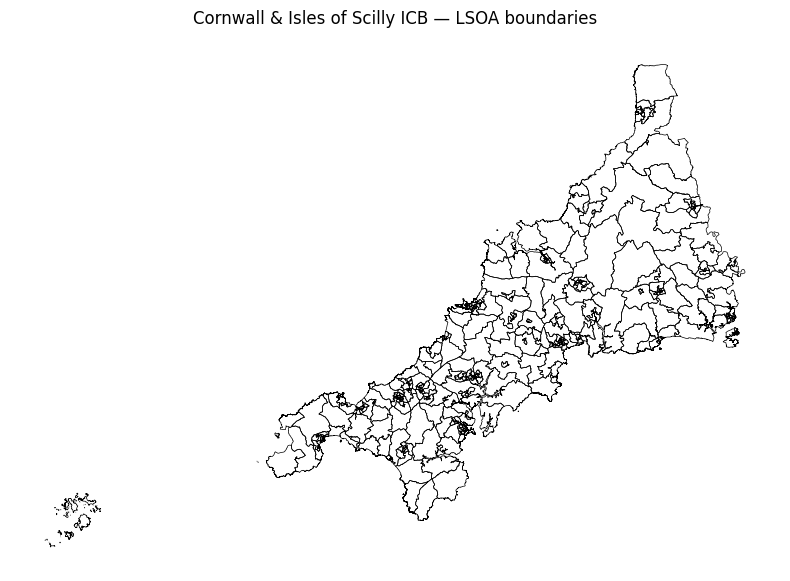

(Basemap skipped: Stamen)
Saved static map to: /Users/rosstaylor/Downloads/Code Repositories/REACH Map (NHS SW)/GitHub Repo/REACH-Map-NHS-SW/data/raw/test_data_ICB_level/cornwall_icb_lsoas.png


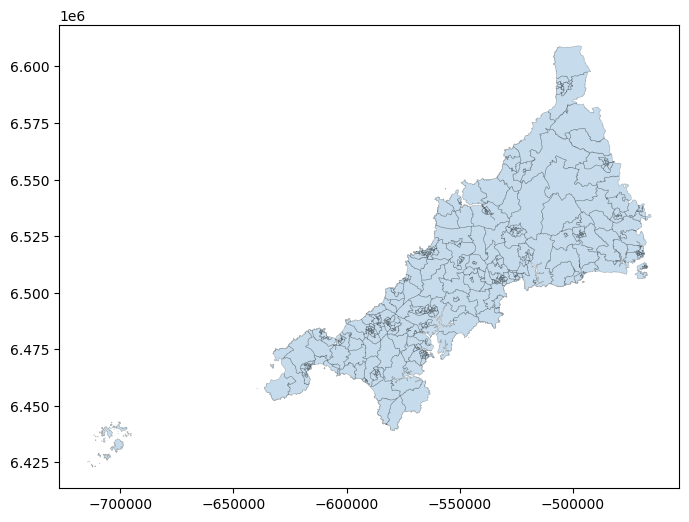

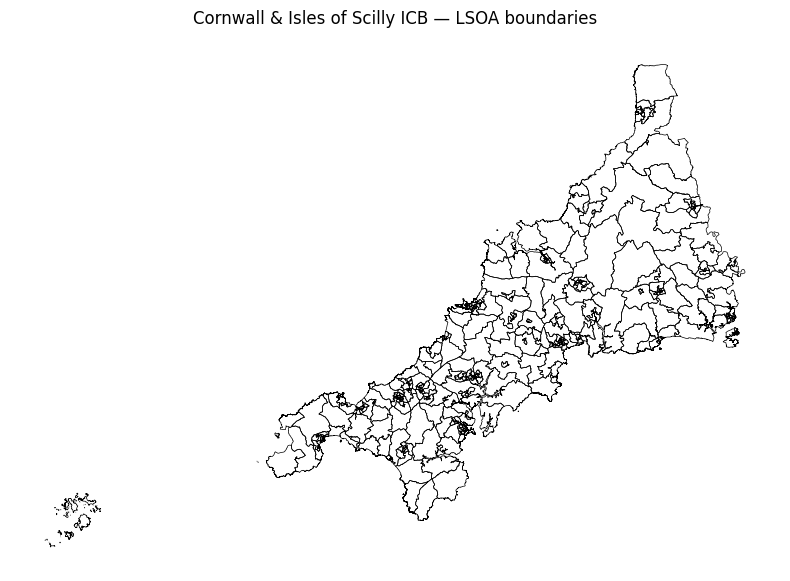

In [5]:
# --- Step 1a: Visualise Cornwall ICB LSOAs (GeoPandas) ---

# Use the GeoDataFrame from Step 1 (should already include a proper 'geometry' column)
gdf = cornwall_lookup.copy()

# Keep only valid geometries
gdf = gdf[gdf.geometry.notnull() & ~gdf.geometry.is_empty]

# 1) Quick outline in native CRS
fig, ax = plt.subplots(figsize=(8, 10))
gdf.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=0.5)
ax.set_title("Cornwall & Isles of Scilly ICB — LSOA boundaries", pad=12)
ax.set_axis_off()
plt.tight_layout()
plt.show()

# 2) Optional: add a basemap (requires 'contextily'; auto-skips if missing)
try:
    import contextily as ctx

    gdf_3857 = gdf.to_crs(epsg=3857)
    fig, ax = plt.subplots(figsize=(8, 10))
    gdf_3857.plot(ax=ax, alpha=0.25, edgecolor="black", linewidth=0.4)
    ctx.add_basemap(ax, source=ctx.providers.Stamen.TerrainBackground)
    ax.set_title("Cornwall & Isles of Scilly ICB — LSOAs (with basemap)", pad=12)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"(Basemap skipped: {e})")

# 3) Save a static PNG (native CRS outline)
out_png = OUT_DIR / "cornwall_icb_lsoas.png"
fig, ax = plt.subplots(figsize=(8, 10))
gdf.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=0.5)
ax.set_title("Cornwall & Isles of Scilly ICB — LSOA boundaries", pad=12)
ax.set_axis_off()
plt.tight_layout()
fig.savefig(out_png, dpi=200)
print(f"Saved static map to: {out_png}")


In [7]:
# --- Step 2: Filter, clean, and rename Rural/Urban Classification to Cornwall ICB ---

# Paths (reuse DATA_ROOT from Step 0)
OUT_DIR = DATA_ROOT / "test_data_ICB_level"
OUT_DIR.mkdir(parents=True, exist_ok=True)

lookup_path = OUT_DIR / "cornwall_icb_lsoa_lookup.csv"
ruc_out_path = OUT_DIR / "ruc_icb.csv"

# 2A) Load Cornwall LSOA lookup (authoritative filter set)
cornwall_lookup = pd.read_csv(lookup_path, dtype={"lsoa_code": "string"})
cornwall_codes = set(cornwall_lookup["lsoa_code"].astype("string"))

print(f"[INFO] Cornwall LSOAs loaded: {len(cornwall_codes):,}")

# 2B) Load RUC 2021 and standardise columns
ruc_raw = pd.read_csv(ruc_path, dtype="string")

rename_map = {
    "LSOA21CD": "lsoa_code",
    "LSOA21NM": "lsoa_name",
    "RUC21CD": "ruc21cd",
    "RUC21NM": "ruc21nm",
    "Urban_rural_flag": "urban_rural_flag",
    # LSOA21NMW and ObjectId are not needed post-standardisation
}
missing_in_raw = [c for c in ["LSOA21CD", "LSOA21NM", "RUC21CD", "RUC21NM", "Urban_rural_flag"] if c not in ruc_raw.columns]
if missing_in_raw:
    raise KeyError(f"Missing expected RUC columns: {missing_in_raw}. Present: {list(ruc_raw.columns)}")

ruc_std = (
    ruc_raw.rename(columns=rename_map)
    .assign(
        lsoa_code=lambda d: d["lsoa_code"].str.strip(),
        lsoa_name=lambda d: d["lsoa_name"].str.strip(),
        ruc21cd=lambda d: d["ruc21cd"].str.strip(),
        ruc21nm=lambda d: d["ruc21nm"].str.strip(),
        urban_rural_flag=lambda d: d["urban_rural_flag"].str.strip(),
    )
)

# 2C) Filter to Cornwall ICB LSOAs only
ruc_cornwall = ruc_std.loc[ruc_std["lsoa_code"].isin(cornwall_codes)].copy()

# 2D) Select final columns, de-duplicate, sort
ruc_cornwall = (
    ruc_cornwall[["lsoa_code", "lsoa_name", "ruc21cd", "ruc21nm", "urban_rural_flag"]]
    .drop_duplicates(subset=["lsoa_code"])
    .sort_values(["ruc21nm", "lsoa_name"])
    .reset_index(drop=True)
)

# 2E) QA: coverage + simple distributions
coverage = len(ruc_cornwall)
expected = len(cornwall_codes)
missing_codes = sorted(cornwall_codes - set(ruc_cornwall["lsoa_code"]))
print(f"[INFO] RUC rows after filter: {coverage:,} / expected {expected:,}")
if missing_codes:
    print(f"[WARN] Missing RUC entries for {len(missing_codes)} LSOAs (showing up to 10): {missing_codes[:10]}")

print("\n[INFO] Urban/rural flag distribution:")
print(ruc_cornwall["urban_rural_flag"].value_counts(dropna=False))

# 2F) Save
ruc_cornwall.to_csv(ruc_out_path, index=False)
print(f"\n[OK] Saved Cornwall RUC to: {ruc_out_path}")


[INFO] Cornwall LSOAs loaded: 336
[INFO] RUC rows after filter: 336 / expected 336

[INFO] Urban/rural flag distribution:
urban_rural_flag
Rural    183
Urban    153
Name: count, dtype: Int64

[OK] Saved Cornwall RUC to: /Users/rosstaylor/Downloads/Code Repositories/REACH Map (NHS SW)/GitHub Repo/REACH-Map-NHS-SW/data/raw/test_data_ICB_level/ruc_icb.csv


In [8]:
# --- Step 3: Filter, clean, and rename General Health (2021) to Cornwall ICB ---

OUT_DIR = DATA_ROOT / "test_data_ICB_level"
OUT_DIR.mkdir(parents=True, exist_ok=True)

lookup_path = OUT_DIR / "cornwall_icb_lsoa_lookup.csv"
gen_health_out_path = OUT_DIR / "demographics_general_health_icb.csv"

# 3A) Load Cornwall LSOA lookup (authoritative filter + names)
cornwall_lookup = pd.read_csv(lookup_path, dtype={"lsoa_code": "string"})
cornwall_codes = set(cornwall_lookup["lsoa_code"].astype("string"))
lsoa_name_map = dict(
    zip(cornwall_lookup["lsoa_code"].astype("string"), cornwall_lookup["lsoa_name"])
)

print(f"[INFO] Cornwall LSOAs loaded: {len(cornwall_codes):,}")

# 3B) Load General Health (2021) and standardise schema
gh_raw = pd.read_csv(general_health_path, dtype={"lsoa21cd": "string"})

required_raw = [
    "lsoa21cd",
    "General health: Total: All usual residents",
    "General health: Very good health",
    "General health: Good health",
    "General health: Fair health",
    "General health: Bad health",
    "General health: Very bad health",
]
missing = [c for c in required_raw if c not in gh_raw.columns]
if missing:
    raise KeyError(f"Missing expected General Health columns: {missing}")

rename_map = {
    "lsoa21cd": "lsoa_code",
    "General health: Total: All usual residents": "population_total",
    "General health: Very good health": "health_very_good",
    "General health: Good health": "health_good",
    "General health: Fair health": "health_fair",
    "General health: Bad health": "health_bad",
    "General health: Very bad health": "health_very_bad",
}

gh_std = (
    gh_raw.rename(columns=rename_map)
    .assign(lsoa_code=lambda d: d["lsoa_code"].str.strip())
)

# Coerce numeric columns
num_cols = [
    "population_total",
    "health_very_good",
    "health_good",
    "health_fair",
    "health_bad",
    "health_very_bad",
]
for col in num_cols:
    gh_std[col] = pd.to_numeric(gh_std[col], errors="coerce")

# 3C) Filter to Cornwall ICB LSOAs only
gh_cornwall = gh_std.loc[gh_std["lsoa_code"].isin(cornwall_codes)].copy()

# 3D) Add LSOA name (from lookup) and tidy
gh_cornwall["lsoa_name"] = gh_cornwall["lsoa_code"].map(lsoa_name_map)
gh_cornwall = gh_cornwall[
    ["lsoa_code", "lsoa_name"] + num_cols
].drop_duplicates(subset=["lsoa_code"])

# 3E) QA: category sums should match total (tolerance 0; report mismatches)
components = ["health_very_good", "health_good", "health_fair", "health_bad", "health_very_bad"]
gh_cornwall["components_sum"] = gh_cornwall[components].sum(axis=1, min_count=1)
gh_cornwall["sum_diff"] = gh_cornwall["population_total"] - gh_cornwall["components_sum"]

mismatch = gh_cornwall[gh_cornwall["sum_diff"].fillna(0) != 0]
print(
    f"[INFO] Rows after filter: {len(gh_cornwall):,} | "
    f"Mismatched totals: {len(mismatch):,}"
)
if not mismatch.empty:
    print("[WARN] First 5 mismatches (population_total vs sum of categories):")
    print(
        mismatch[
            ["lsoa_code", "lsoa_name", "population_total", "components_sum", "sum_diff"]
        ].head(5)
    )

# Drop QA helper columns before save
gh_cornwall = gh_cornwall.drop(columns=["components_sum", "sum_diff"])

# 3F) Sort and save
gh_cornwall = gh_cornwall.sort_values(["lsoa_name"]).reset_index(drop=True)
gh_cornwall.to_csv(gen_health_out_path, index=False)
print(f"[OK] Saved Cornwall General Health to: {gen_health_out_path}")


[INFO] Cornwall LSOAs loaded: 336
[INFO] Rows after filter: 336 | Mismatched totals: 0
[OK] Saved Cornwall General Health to: /Users/rosstaylor/Downloads/Code Repositories/REACH Map (NHS SW)/GitHub Repo/REACH-Map-NHS-SW/data/raw/test_data_ICB_level/demographics_general_health_icb.csv


In [9]:
# --- Step 4: Filter, clean, and rename IMD 2019 to Cornwall ICB ---

OUT_DIR = DATA_ROOT / "test_data_ICB_level"
OUT_DIR.mkdir(parents=True, exist_ok=True)

lookup_path = OUT_DIR / "cornwall_icb_lsoa_lookup.csv"
imd_out_path = OUT_DIR / "imd_icb.csv"

# 4A) Load Cornwall LSOA lookup (authoritative filter + names)
cornwall_lookup = pd.read_csv(lookup_path, dtype={"lsoa_code": "string"})
cornwall_codes = set(cornwall_lookup["lsoa_code"].astype("string"))
lsoa_name_map = dict(
    zip(cornwall_lookup["lsoa_code"].astype("string"), cornwall_lookup["lsoa_name"])
)

print(f"[INFO] Cornwall LSOAs loaded: {len(cornwall_codes):,}")

# 4B) Load IMD 2019 and standardise schema
imd_raw = pd.read_csv(imd_path, dtype={"lsoa21cd": "string"})

required_raw = ["lsoa21cd", "IMD19"]
missing = [c for c in required_raw if c not in imd_raw.columns]
if missing:
    raise KeyError(f"Missing expected IMD columns: {missing}. Present: {list(imd_raw.columns)}")

imd_std = (
    imd_raw.rename(columns={"lsoa21cd": "lsoa_code", "IMD19": "imd19"})
    .assign(lsoa_code=lambda d: d["lsoa_code"].str.strip())
)

# Coerce IMD to numeric (works for rank or score); keep NaNs if any
imd_std["imd19"] = pd.to_numeric(imd_std["imd19"], errors="coerce")

# 4C) Filter to Cornwall ICB LSOAs only
imd_cornwall = imd_std.loc[imd_std["lsoa_code"].isin(cornwall_codes)].copy()

# 4D) Add LSOA name, finalise columns
imd_cornwall["lsoa_name"] = imd_cornwall["lsoa_code"].map(lsoa_name_map)
imd_cornwall = (
    imd_cornwall[["lsoa_code", "lsoa_name", "imd19"]]
    .drop_duplicates(subset=["lsoa_code"])
    .sort_values(["lsoa_name"])
    .reset_index(drop=True)
)

# 4E) QA: coverage + simple stats
coverage = len(imd_cornwall)
expected = len(cornwall_codes)
missing_codes = sorted(cornwall_codes - set(imd_cornwall["lsoa_code"]))
print(f"[INFO] IMD rows after filter: {coverage:,} / expected {expected:,}")
if missing_codes:
    print(f"[WARN] Missing IMD entries for {len(missing_codes)} LSOAs (showing up to 10): {missing_codes[:10]}")

print("\n[INFO] IMD19 summary (min/median/max):")
print(
    imd_cornwall["imd19"].agg(["min", "median", "max"]).to_frame(name="imd19").T
)

# 4F) Save
imd_cornwall.to_csv(imd_out_path, index=False)
print(f"\n[OK] Saved Cornwall IMD (2019) to: {imd_out_path}")


[INFO] Cornwall LSOAs loaded: 336
[INFO] IMD rows after filter: 336 / expected 336

[INFO] IMD19 summary (min/median/max):
          min     median        max
imd19 577.000 12,680.000 28,717.000

[OK] Saved Cornwall IMD (2019) to: /Users/rosstaylor/Downloads/Code Repositories/REACH Map (NHS SW)/GitHub Repo/REACH-Map-NHS-SW/data/raw/test_data_ICB_level/imd_icb.csv


In [10]:
# --- Step 5 (robust): Build Cornwall travel matrix (car) handling NAME or CODE in source ---

OUT_DIR = DATA_ROOT / "test_data_ICB_level"
OUT_DIR.mkdir(parents=True, exist_ok=True)

lookup_path = OUT_DIR / "cornwall_icb_lsoa_lookup.csv"
travel_out_path = OUT_DIR / "travel_matrix_lsoa_icb.csv"

# 5A) Load Cornwall LSOA lookup (authoritative names/codes)
cornwall_lookup = pd.read_csv(
    lookup_path, dtype={"lsoa_code": "string", "lsoa_name": "string"}
)
cornwall_codes = set(cornwall_lookup["lsoa_code"].astype("string"))

# Helper maps
def _norm(s: pd.Series) -> pd.Series:
    return s.astype("string").str.strip()

code_to_name = dict(
    zip(
        cornwall_lookup["lsoa_code"].astype("string"),
        cornwall_lookup["lsoa_name"].astype("string"),
    )
)
name_to_code = dict(zip(_norm(cornwall_lookup["lsoa_name"]).str.casefold(),
                        cornwall_lookup["lsoa_code"].astype("string")))

# Code detection utility
CODE_RE = re.compile(r"^E\d{8}$")  # ONS LSOA code pattern

def series_looks_like_codes(s: pd.Series, threshold: float = 0.8) -> bool:
    s = _norm(s).dropna()
    if s.empty:
        return False
    share = s.map(lambda x: bool(CODE_RE.match(x))).mean()
    return share >= threshold

# 5B) Load travel matrix
travel_raw = pd.read_csv(
    travel_matrix_path,
    dtype={"origin_name": "string", "destination_name": "string"},
)
required_raw = ["origin_name", "destination_name", "travel_time_car"]
missing = [c for c in required_raw if c not in travel_raw.columns]
if missing:
    raise KeyError(f"Missing expected travel columns: {missing}. Present: {list(travel_raw.columns)}")

travel = travel_raw.assign(
    origin_name=_norm(travel_raw["origin_name"]),
    destination_name=_norm(travel_raw["destination_name"]),
)
travel["time_car_min"] = pd.to_numeric(travel["travel_time_car"], errors="coerce")

# 5C) Determine whether origin/destination are NAMES or CODES
origin_is_code = series_looks_like_codes(travel["origin_name"])
dest_is_code = series_looks_like_codes(travel["destination_name"])
print(f"[INFO] Detected format — origin codes: {origin_is_code}, destination codes: {dest_is_code}")

if origin_is_code and dest_is_code:
    # Treat as codes directly
    travel["origin_lsoa"] = travel["origin_name"]
    travel["dest_lsoa"] = travel["destination_name"]
    travel["origin_lsoa_name"] = travel["origin_lsoa"].map(code_to_name)
    travel["dest_lsoa_name"] = travel["dest_lsoa"].map(code_to_name)
else:
    # Treat as names → map to codes (case-insensitive)
    travel["_origin_norm"] = travel["origin_name"].str.casefold()
    travel["_dest_norm"] = travel["destination_name"].str.casefold()
    travel["origin_lsoa"] = travel["_origin_norm"].map(name_to_code)
    travel["dest_lsoa"] = travel["_dest_norm"].map(name_to_code)
    travel["origin_lsoa_name"] = travel["origin_name"]
    travel["dest_lsoa_name"] = travel["destination_name"]

# 5D) Show unmatched cases (should be 0 ideally)
unmatched_origin = (
    travel.loc[travel["origin_lsoa"].isna(), "origin_name"].drop_duplicates().head(10)
)
unmatched_dest = (
    travel.loc[travel["dest_lsoa"].isna(), "destination_name"].drop_duplicates().head(10)
)
if not unmatched_origin.empty or not unmatched_dest.empty:
    print("[WARN] Unmatched origin values (sample up to 10):", unmatched_origin.to_list())
    print("[WARN] Unmatched destination values (sample up to 10):", unmatched_dest.to_list())

# 5E) Filter to within-ICB OD pairs
mask_icb = (
    travel["origin_lsoa"].notna()
    & travel["dest_lsoa"].notna()
    & travel["origin_lsoa"].isin(cornwall_codes)
    & travel["dest_lsoa"].isin(cornwall_codes)
)

travel_icb = travel.loc[mask_icb].copy()

# Drop self-loops unless needed
travel_icb = travel_icb.loc[travel_icb["origin_lsoa"] != travel_icb["dest_lsoa"]]

# Keep tidy set of columns
travel_icb = travel_icb[
    [
        "origin_lsoa",
        "dest_lsoa",
        "origin_lsoa_name",
        "dest_lsoa_name",
        "time_car_min",
    ]
]

# 5F) QA: non-negative times, density vs expected N^2 (minus diagonal)
neg_times = travel_icb.loc[travel_icb["time_car_min"] < 0]
if not neg_times.empty:
    print(f"[WARN] {len(neg_times)} rows have negative times (kept).")

n_codes = len(cornwall_codes)
expected_pairs = n_codes * (n_codes - 1)  # without diagonal
actual_pairs = len(travel_icb)
coverage_pct = (actual_pairs / expected_pairs * 100) if expected_pairs else 0.0

print(
    f"[INFO] OD pairs within ICB: {actual_pairs:,} | "
    f"Expected (max): {expected_pairs:,} | "
    f"Coverage: {coverage_pct:,.1f}%"
)

# 5G) Save
travel_icb = travel_icb.sort_values(["origin_lsoa", "dest_lsoa"]).reset_index(drop=True)
travel_icb.to_csv(travel_out_path, index=False)
print(f"[OK] Saved Cornwall travel matrix (car) to: {travel_out_path}")


[INFO] Detected format — origin codes: True, destination codes: True
[INFO] OD pairs within ICB: 112,560 | Expected (max): 112,560 | Coverage: 100.0%
[OK] Saved Cornwall travel matrix (car) to: /Users/rosstaylor/Downloads/Code Repositories/REACH Map (NHS SW)/GitHub Repo/REACH-Map-NHS-SW/data/raw/test_data_ICB_level/travel_matrix_lsoa_icb.csv


In [11]:
# --- Step 6 (simpler): Cornwall-only slice for continuous ages (retain all columns) ---

OUT_DIR = DATA_ROOT / "test_data_ICB_level"
OUT_DIR.mkdir(parents=True, exist_ok=True)

lookup_path = OUT_DIR / "cornwall_icb_lsoa_lookup.csv"
age_cont_out_gpkg = OUT_DIR / "demographics_age_continuous_icb.gpkg"
age_cont_layer_out = "LSOA_continuous_age_icb"  # output layer name

# 6A) Load Cornwall LSOAs (authoritative list)
cornwall_lookup = pd.read_csv(lookup_path, dtype={"lsoa_code": "string"})
cornwall_codes = set(cornwall_lookup["lsoa_code"].astype("string"))

# 6B) Read the source continuous-age layer (retain all columns)
gdf_cont = gpd.read_file(age_continuous_gpkg, layer=age_continuous_layer)

# 6C) Minimal standardisation: rename code/name columns if present
rename_candidates = {}
# Code column
if "lsoa_code" in gdf_cont.columns:
    pass  # already standard
elif "lsoa21cd" in gdf_cont.columns:
    rename_candidates["lsoa21cd"] = "lsoa_code"
# Name column (pick the first that exists; leave others untouched)
for cand in ["lsoa_name", "lsoa21nm", "lsoa21nm_y", "lsoa21nm_x", "lsoa21nmw"]:
    if cand in gdf_cont.columns:
        if cand != "lsoa_name":
            rename_candidates[cand] = "lsoa_name"
        break

if rename_candidates:
    gdf_cont = gdf_cont.rename(columns=rename_candidates)

# Ensure code/name are strings (no other coercions)
if "lsoa_code" in gdf_cont.columns:
    gdf_cont["lsoa_code"] = gdf_cont["lsoa_code"].astype("string").str.strip()
if "lsoa_name" in gdf_cont.columns:
    gdf_cont["lsoa_name"] = gdf_cont["lsoa_name"].astype("string").str.strip()

# 6D) Filter to Cornwall-only rows using lsoa_code
if "lsoa_code" not in gdf_cont.columns:
    raise KeyError("Expected 'lsoa_code' after rename, but it is missing.")
gdf_cornwall = gdf_cont[gdf_cont["lsoa_code"].isin(cornwall_codes)].copy()

print(f"[INFO] Continuous-age rows after Cornwall filter: {len(gdf_cornwall):,} / {len(gdf_cont):,}")

# 6E) Save as-is (all columns retained), sorted by name if available
if "lsoa_name" in gdf_cornwall.columns:
    gdf_cornwall = gdf_cornwall.sort_values("lsoa_name").reset_index(drop=True)
else:
    gdf_cornwall = gdf_cornwall.sort_values("lsoa_code").reset_index(drop=True)

gdf_cornwall.to_file(age_cont_out_gpkg, layer=age_cont_layer_out, driver="GPKG")
print(f"[OK] Saved Cornwall continuous-age (all columns retained) to: {age_cont_out_gpkg} (layer='{age_cont_layer_out}')")


[INFO] Continuous-age rows after Cornwall filter: 336 / 3,451
[OK] Saved Cornwall continuous-age (all columns retained) to: /Users/rosstaylor/Downloads/Code Repositories/REACH Map (NHS SW)/GitHub Repo/REACH-Map-NHS-SW/data/raw/test_data_ICB_level/demographics_age_continuous_icb.gpkg (layer='LSOA_continuous_age_icb')
